In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-for-msc-coursework-2021/example.csv
/kaggle/input/deep-learning-for-msc-coursework-2021/train.csv
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10188.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10107.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10124.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10316.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10106.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10149.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10163.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10272.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10062.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10054.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10104.png
/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/10299.png
/kaggle/in

# **Import library**

In [2]:
# libraries of reading and displaying pictures

from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

# libraries of Pytorch
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# library of Validation set
from sklearn.model_selection import train_test_split

# libraries of models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torchvision import models

# **Prepare training Data**

Import csv files

In [3]:
train_data = pd.read_csv("/kaggle/input/deep-learning-for-msc-coursework-2021/train.csv")
example_data = pd.read_csv("/kaggle/input/deep-learning-for-msc-coursework-2021/example.csv")
print(train_data.head())
print(example_data.head())
#print the size of training data and example data
print(f'Size of training data: {train_data.shape}')
print(f'Size of training data: {example_data.shape}')


   Id        Type
0   1  Connective
1   2  Connective
2   3  Connective
3   4  Connective
4   5  Connective
      Id    Type
0  10001  Normal
1  10002  Normal
2  10003  Normal
3  10004  Normal
4  10005  Normal
Size of training data: (2190, 2)
Size of training data: (400, 2)


Load training images and process them

In [4]:
# Load training images
train_img = []
for img_name in tqdm(train_data['Id']):
    image_path = '/kaggle/input/deep-learning-for-msc-coursework-2021/train/train/' + str(img_name) + '.png'
    img = imread(image_path)
    # process image
    img = img/255
    img = resize(img, output_shape=(64,64,3), mode= 'constant' , anti_aliasing=True)
    img = img.astype('float32')
    train_img.append(img)

100%|██████████| 2190/2190 [00:16<00:00, 136.62it/s]


See Total In count

<AxesSubplot:>

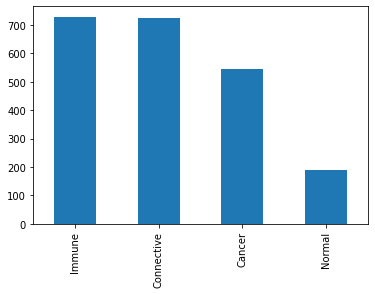

In [5]:
train_data['Type'].value_counts().plot.bar()

We will convert the target to torch, We need to convert column 'Type' into int.
So we  convert 'Immune'to 0, 'Connective'to 1, 'Cancer'to 2,'Normal'to 3.


<AxesSubplot:>

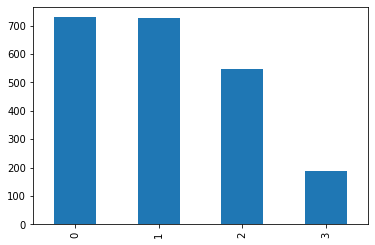

In [6]:
train_data["Type"] = train_data["Type"].replace({'Immune': 0, 'Connective':1, 'Cancer':2,'Normal':3})
train_data['Type'].value_counts().plot.bar()

# Create training  set and validation set

In [7]:
# convert into numpy
train_x = np.array(train_img)
# Define targets
train_y = train_data['Type'].values
train_x.shape

(2190, 64, 64, 3)

In [8]:
# creat validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((1971, 64, 64, 3), (1971,)), ((219, 64, 64, 3), (219,)))

# Convert images to torch 

In [9]:
# convert traning images to torch
train_x = train_x.reshape(1971,3,64,64)
train_x  = torch.Tensor(train_x)
#convert targets to torch
train_y=torch.LongTensor(train_y)
# the shape of traning set
print(train_x.shape, train_y.shape)
#the type of traning set
print(train_x.dtype,train_y.dtype)

# convert test images to torch
val_x = val_x.reshape(219, 3, 64, 64)
val_x  = torch.Tensor(val_x)
#convert targets to torch
val_y=torch.LongTensor(val_y)
# the shape of validation set
print(val_x.shape, val_y.shape)
#the type of validation set
print(val_x.dtype,val_y.dtype)

torch.Size([1971, 3, 64, 64]) torch.Size([1971])
torch.float32 torch.int64
torch.Size([219, 3, 64, 64]) torch.Size([219])
torch.float32 torch.int64


# Define model

In [10]:
torch.manual_seed(0)

class Cnn(Module):   
    def __init__(self):
        super(Cnn, self).__init__()

        self.cnn_layers = Sequential(
            # Convolutional layer
            Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            #Batch Normalization layer
            #BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
            # another Convolutional layer
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            #Batch Normalization layer
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(8192, 1024),
            ReLU(inplace=True),
            Dropout(0.5),
            Linear(1024, 512),
            ReLU(inplace=True),
            Dropout(0.5),
            Linear(512, 4),
#             Softmax(dim=1)
        )

    # 前项传播
    def forward(self, x):
        x = self.cnn_layers(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.linear_layers(x)
        return x



# Define model parameters

In [11]:
model = Cnn()
# 定义优化器
optimizer = Adam(model.parameters(), lr=0.0001)
# 定义loss函数
criterion = CrossEntropyLoss()

# model = model.to(device)
# criterion = criterion.to(device)
    
print(model)

Cnn(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=4, bias=True)
  )
)


# Training model

In [12]:
torch.manual_seed(0)

# the size of batch
batch_size = 128

# epoch
n_epochs = 18

for epoch in range(1, n_epochs+1):

    train_loss = 0.0

    permutation = torch.randperm(train_x.size()[0])

    training_loss = []
    for i in tqdm(range(0,train_x.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = train_x[indices], train_y[indices]

        #clear gradient
        optimizer.zero_grad()

        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)
       #update weights
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    training_loss = np.average(training_loss)
    print( epoch,training_loss)
    

  0%|          | 0/16 [00:00<?, ?it/s]

1 1.2126355469226837


  0%|          | 0/16 [00:00<?, ?it/s]

2 1.0226962827146053


  0%|          | 0/16 [00:00<?, ?it/s]

3 0.9386918470263481


  0%|          | 0/16 [00:00<?, ?it/s]

4 0.8612200133502483


  0%|          | 0/16 [00:00<?, ?it/s]

5 0.8109765648841858


  0%|          | 0/16 [00:00<?, ?it/s]

6 0.7697641514241695


  0%|          | 0/16 [00:00<?, ?it/s]

7 0.7264580577611923


  0%|          | 0/16 [00:00<?, ?it/s]

8 0.6930558942258358


  0%|          | 0/16 [00:00<?, ?it/s]

9 0.6590745747089386


  0%|          | 0/16 [00:00<?, ?it/s]

10 0.6308460272848606


  0%|          | 0/16 [00:00<?, ?it/s]

11 0.5885147508233786


  0%|          | 0/16 [00:00<?, ?it/s]

12 0.5562397167086601


  0%|          | 0/16 [00:00<?, ?it/s]

13 0.5201349500566721


  0%|          | 0/16 [00:00<?, ?it/s]

14 0.47990570962429047


  0%|          | 0/16 [00:00<?, ?it/s]

15 0.43820418044924736


  0%|          | 0/16 [00:00<?, ?it/s]

16 0.41045971401035786


  0%|          | 0/16 [00:00<?, ?it/s]

17 0.36926285922527313


100%|██████████| 16/16 [00:04<00:00,  3.63it/s]

18 0.33866595290601254


# Training set accuracy

In [13]:
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

accuracy_score(train_y, predictions)

0.9020801623541349

# Verification set accuracy

In [14]:
with torch.no_grad():
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

accuracy_score(val_y, predictions)


0.7123287671232876

# Prepare test data

Load test images and process them

In [15]:

test_img = []
for img_name in tqdm(example_data['Id']):
    image_path = image_path = '/kaggle/input/deep-learning-for-msc-coursework-2021/test/test/' + str(img_name) + '.png'
    img = imread(image_path)
    # process image
    img = img/255
    img = resize(img, output_shape=(64,64,3), mode= 'constant' , anti_aliasing=True)
    img = img.astype('float32')
    test_img.append(img)

# convert to numpy
test_x = np.array(test_img)
print(test_x.shape)


100%|██████████| 400/400 [00:02<00:00, 133.60it/s]

(400, 64, 64, 3)


convert to torch

In [16]:
test_x = test_x.reshape(400,3, 64, 64)
test_x  = torch.from_numpy(test_x)
test_x.shape


torch.Size([400, 3, 64, 64])

# Generate test set

In [17]:
with torch.no_grad():
    output = model(test_x)   
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

Replace 'Type' in the example csv file with the prediction

In [18]:

example_data['Type'] = predictions
example_data["Type"] = example_data["Type"].replace({ 0:'Immune', 1:'Connective', 2:'Cancer',3:'Normal'})
example_data.head()

,Id,Type
0,10001,Cancer
1,10002,Cancer
2,10003,Immune
3,10004,Immune
4,10005,Connective


 Finally, save the file 

In [19]:
example_data.to_csv('submission.csv', index=False)